**Deep Learning model**

This notebook shows an attempt to predict ups or downs in the 
price of BTC during day following randomly sampled sequences of consequtive days

In [75]:
"""Do all the necessary imports"""

import pandas as pd
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Flatten, GRU, LSTM
from tensorflow.keras import layers
from tensorflow.keras.layers import Masking
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import talib
from talib import RSI, WILLR, CDLDOJI, CDLHAMMER, CDLHANGINGMAN, CDLRISEFALL3METHODS, NATR, ADOSC, MOM, HT_DCPERIOD
from datetime import datetime


DATA PREPARATION

In [76]:
"""In this algorithm, we tried to include the close of the NASDAQ and the 
close of the S&P for each day. This was done to identify potential spillover
effects between the BTC and the traditional financial markets. Overall, this
addition improved our results."""


"""Handling of data NASDAQ"""
data_nasdaq=pd.read_csv("/Users/Axel/Desktop/HistoricalPricesNASDAQ.csv")

"""Only keep the desired columns"""
data_nasdaq = data_nasdaq[["Date"," Close"]]

"""Rename the column"""
data_nasdaq["Close Nasdaq"] = data_nasdaq[" Close"]

"""Drop the Close column"""
data_nasdaq=data_nasdaq.drop(columns=[" Close"])

"""Convert the date to datetye format"""
data_nasdaq['Date'] = data_nasdaq['Date'].astype('datetime64[ns]')


"""Inverse the order of the data to have the oldest first"""
data_nasdaq=data_nasdaq.reindex(index=data_nasdaq.index[::-1])

#"""Select the data for a period matching the period in which we have data for BTC"""
#data_nasdaq = data_nasdaq.iloc[1:]


"""Handling of data S&P"""
data_sp = pd.read_csv("/Users/Axel/Desktop/HistoricalPricesS&P.csv")

"""Only keep the desired columns"""
data_sp = data_sp[["Date"," Close"]]

"""Rename the column"""
data_sp["Close S&P"] = data_sp[" Close"]

"""Drop the Close column"""
data_sp=data_sp.drop(columns=[" Close"])

"""Inverse the order of the data to have the oldest first"""
data_sp=data_sp.reindex(index=data_sp.index[::-1])

"""Convert the date to datetype format"""
data_sp['Date'] = data_sp['Date'].astype('datetime64[ns]')
#data_sp=data_sp.iloc[:-2]

In [77]:
data_nasdaq

,Date,Close Nasdaq
1276,2017-06-01,6246.83
1275,2017-06-02,6305.80
1274,2017-06-05,6295.68
1273,2017-06-06,6275.06
1272,2017-06-07,6297.38
...,...,...
4,2022-06-21,11069.30
3,2022-06-22,11053.08
2,2022-06-23,11232.19
1,2022-06-24,11607.62


In [78]:
data_sp

,Date,Close S&P
1276,2017-06-01,2430.06
1275,2017-06-02,2439.07
1274,2017-06-05,2436.10
1273,2017-06-06,2429.33
1272,2017-06-07,2433.14
...,...,...
4,2022-06-21,3764.79
3,2022-06-22,3759.89
2,2022-06-23,3795.73
1,2022-06-24,3911.74


In [79]:
"""Handling of the combined S&P and Nasdaq and and address the issue that 
there is no data for the closes during weekend."""

"""Create an empty dataframe with only date the correspond to our period 
of interest (here starting in summer 2017 after the launch of binance). This df
will also include the weekends"""
date_df=pd.DataFrame(pd.date_range(start="2017-08-21",end="2022-05-27"),columns=["Date"])

"""Merge the data from nasdaq and s&p with the date data frame"""
date_df=date_df.merge(data_sp,on="Date",how="left")
date_df=date_df.merge(data_nasdaq,on="Date",how="left")

"""Use the "ffill" method to fill the n/a (closes values during the weekends)
with the last non n/a values"""
date_df=date_df.fillna(method="ffill")

In [80]:
"""Handling of the BTC data"""

data=pd.read_csv("/Users/Axel/code/a4xel/Projet/nlp_predict_bitcoin_pricing/data/BTC_Dataframe_daily.csv")

"""Create a new column populated by the movement during the day"""
data["Movement_daily"] = data["Close"] - data["Open"]

"""Create our binary response variable which corresponds has 1 if the movement
during the day is positive and 0 if negative"""
data["Movement_daily_binary"] = [1 if i > 0 else -1 for i in data["Movement_daily"]]

#data["Movement_next_period"]=data["Movement_daily"].shift(-1)
#data["Movement_predict_categorical"] = data["Movement_daily"].apply(to_categorical)
#data["Movement_predict_binary"] = [1 if i>0 else -1 for i in data["Movement_next_period"]]
data.dropna(inplace=True)
data


,Date,High,Low,Open,Close,Volume,Movement_daily,Movement_daily_binary
0,2013-04-29,147.488007,134.000000,134.444000,144.539993,0.00000,10.095993,1
1,2013-04-30,146.929993,134.050003,144.000000,139.000000,0.00000,-5.000000,-1
2,2013-05-01,139.889999,107.720001,139.000000,116.989998,0.00000,-22.010002,-1
3,2013-05-02,125.599998,92.281898,116.379997,105.209999,0.00000,-11.169998,-1
4,2013-05-03,108.127998,79.099998,106.250000,97.750000,0.00000,-8.500000,-1
...,...,...,...,...,...,...,...,...
3314,2022-05-26,29886.640000,28019.560000,29542.140000,29201.350000,94581.65463,-340.790000,-1
3315,2022-05-27,29397.660000,28282.900000,29201.350000,28629.800000,90998.52010,-571.550000,-1
3316,2022-05-28,29266.000000,28450.000000,28629.810000,29031.330000,34479.35127,401.520000,1
3317,2022-05-29,29587.780000,28839.210000,29031.330000,29468.100000,27567.34764,436.770000,1


In [81]:
"""Handling of the technical indicators using the TALIB library
(see the read.me file for more details)"""

data["RSI"]= RSI(data["Close"], timeperiod=13)
data["WILLR"] = WILLR(data["High"],data["Low"], data["Close"],timeperiod=14)
data["CDLDOJI"] = CDLDOJI(data["Open"],data["High"],data["Low"],data["Close"])
data["CDLHAMMER"] = CDLHAMMER(data["Open"],data["High"],data["Low"],data["Close"])
data["CDLHANGINGMAN"] = CDLHANGINGMAN(data["Open"],data["High"],data["Low"],data["Close"])
data["NATR"] = NATR(data["High"],data["Low"], data["Close"],timeperiod=13)
data["ADOSC"] = ADOSC(data["High"],data["Low"],data["Close"],data["Volume"],fastperiod=3, slowperiod=10)
data["MOM"] = MOM(data["Close"], timeperiod = 14)




In [82]:
"""Merging the dataframes,removing the NAs and setting the period, 
removing the date column to allow scaling"""

data=data.dropna()

"""Convert date as datetype to allow merging"""
data['Date'] = data['Date'].astype('datetime64[ns]')

"""Merge BTC data with the Nasdaq and S&P data """
data=data.merge(date_df,on="Date",how="left")

"""Select only the data during our period of interest"""
mask = pd.to_datetime(data['Date']) > '20/08/2017'
data=data[mask]
data=data.drop(columns=["Date"])
data



/var/folders/hb/nmlv1q8d051bmdr61wm2yhsc0000gp/T/ipykernel_99583/1368248179.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data['Date'].astype('datetime64[ns]')


,High,Low,Open,Close,Volume,Movement_daily,Movement_daily_binary,RSI,WILLR,CDLDOJI,CDLHAMMER,CDLHANGINGMAN,NATR,ADOSC,MOM,Close S&P,Close Nasdaq
1561,4119.62,3911.79,4069.13,4016.00,691.743060,-53.13,-1,63.326886,-37.923761,0,0,0,6.640422,1.751012e+09,637.060059,2428.37,6213.13
1562,4104.82,3400.00,4016.00,4040.00,966.684858,24.00,1,63.905333,-35.984712,100,0,0,7.435210,1.447901e+09,620.060059,2452.51,6297.48
1563,4265.80,4013.89,4040.00,4114.01,1001.136565,74.01,1,65.712083,-31.852957,0,0,0,7.210820,1.192274e+09,771.540029,2444.04,6278.41
1564,4371.68,4085.01,4147.00,4316.01,787.418753,169.01,1,70.132622,-15.214640,0,0,0,6.855541,9.793105e+08,934.729971,2438.97,6271.33
1565,4453.91,4247.48,4316.01,4280.68,573.612740,-35.33,-1,68.460273,-18.860502,100,0,0,6.751372,8.031608e+08,630.059883,2443.05,6265.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3300,29886.64,28019.56,29542.14,29201.35,94581.654630,-340.79,-1,38.226475,-65.650033,0,0,0,6.260090,-3.656168e+03,171.600000,4057.84,11740.65
3301,29397.66,28282.90,29201.35,28629.80,90998.520100,-571.55,-1,36.355594,-82.262734,0,0,0,6.193420,-1.122149e+04,-657.250000,4158.24,12131.13
3302,29266.00,28450.00,28629.81,29031.33,34479.351270,401.52,1,38.641115,-70.591843,0,0,0,5.854144,-8.635587e+03,-1055.410000,NaN,NaN
3303,29587.78,28839.21,29031.33,29468.10,27567.347640,436.77,1,41.132261,-56.228734,0,0,0,5.519136,-8.259574e+02,-1860.790000,NaN,NaN


In [83]:
"""We split the dataset into a train and a test set
We realize the split at 90% to maximize the training data"""

len = int(0.9*data.shape[0])
df_train = data[:len]
df_test = data[len:]



In [84]:
#f= df_train["Movement_predict_categorical"]
#f=f.reset_index(drop=True)
#f

DATA SCALING

In [85]:
"""Scaling the Data Frames and retrieving the column names"""

"""We use a MinMax scaler to scale our data"""
scaler = MinMaxScaler(feature_range=(0,1))

"""We scale the train and test data"""
df_train_scaled = scaler.fit_transform(df_train)
df_test_scaled = scaler.transform(df_test)

"""As the minmaxscaler erases the columns, we set our scaled data as dataframes
and we give them them column names of the unscaled data frames"""
df_train_scale_DF = pd.DataFrame(df_train_scaled)
df_train_scale_DF.columns=df_train.columns
df_test_scaled_DF = pd.DataFrame(df_test_scaled)
df_test_scaled_DF.columns=df_test.columns
#df_train_scale_DF["Movement_predict_categorical"] = f

In [86]:
df_train_scale_DF

,High,Low,Open,Close,Volume,Movement_daily,Movement_daily_binary,RSI,WILLR,CDLDOJI,CDLHAMMER,CDLHANGINGMAN,NATR,ADOSC,MOM,Close S&P,Close Nasdaq
0,0.012828,0.017267,0.013695,0.012854,0.001153,0.477878,0.0,0.636089,0.618054,0.0,0.0,1.0,0.245058,1.000000,0.574017,0.077405,0.002049
1,0.012603,0.009195,0.012869,0.013227,0.001837,0.483155,1.0,0.642938,0.637628,1.0,0.0,1.0,0.285807,0.826902,0.573614,0.087190,0.010600
2,0.015052,0.018877,0.013242,0.014377,0.001923,0.486576,1.0,0.664332,0.679338,0.0,0.0,1.0,0.274302,0.680921,0.577204,0.083757,0.008666
3,0.016663,0.019998,0.014906,0.017517,0.001391,0.493075,1.0,0.716675,0.847301,0.0,0.0,1.0,0.256087,0.559304,0.581071,0.081702,0.007949
4,0.017915,0.022561,0.017532,0.016968,0.000860,0.479096,0.0,0.696873,0.810496,1.0,0.0,1.0,0.250746,0.458710,0.573851,0.083356,0.007372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1564,0.823130,0.835272,0.839259,0.828318,0.092906,0.433371,0.0,0.407340,0.471872,0.0,0.0,1.0,0.164397,0.000044,0.549174,0.948345,0.931459
1565,0.826546,0.770644,0.828381,0.783564,0.146028,0.284274,0.0,0.333073,0.223655,0.0,0.0,1.0,0.200854,0.000040,0.453438,0.932671,0.901468
1566,0.769627,0.617980,0.783568,0.714419,0.283539,0.177188,0.0,0.247012,0.391858,0.0,0.0,1.0,0.297969,0.000043,0.308792,0.932671,0.901468
1567,0.706331,0.708303,0.714424,0.718210,0.112825,0.498196,1.0,0.256322,0.419418,1.0,0.0,1.0,0.281660,0.000051,0.340294,0.932671,0.901468


DATA SAMPLING

In [87]:
'''The following functions are used to create ramdom sequences of consequtive days.
We can choose the number of sequences we want to sample as well as the 
number of days in each sequence. The functions then randomly selects sequences 
in the data set. The y list is populated with the response variable. In this case,
this variable can be found in the "Movement_daily_binary" column and has 1 if 
the BTC went up in a period and 0 if it went down. For each sequence, the function
selects the movement for the day that follows the last day of the sequence. Hence,
our algorithm can be trained to predict the movement of next period with data 
from the past. Finally, the function returns arrays in a shape suitable to be 
used in a LSTM or GRU model'''

def subsample_sequence(df, length):

    # $CHALLENGIFY_BEGIN
    last_possible = df.shape[0] - length

    random_start = np.random.randint(0, last_possible)
    df_sample = df[random_start: random_start+length]
    # $CHALLENGIFY_END
    return df_sample

def split_subsample_sequence(df, length):
    '''Create one single random (X,y) pair'''
    # $CHALLENGIFY_BEGIN
    df_subsample = subsample_sequence(df, length)
    y_sample = df_subsample.iloc[length -1]['Movement_daily_binary']

    X_sample = df_subsample[0:length -1]
    X_sample = X_sample.values
    # $CHALLENGIFY_END
    return np.array(X_sample), np.array(y_sample)


def get_X_y(df, n_sequences, length):
    '''Return a list of samples (X, y)'''
    # $CHALLENGIFY_BEGIN
    X, y = [], []

    for i in range(n_sequences):
        (xi, yi) = split_subsample_sequence(df, length)
        X.append(xi)
        y.append(yi)

    X = np.array(X)
    y = np.array(y)
    # $CHALLENGIFY_END
    return X, y

In [88]:
"""We use the previously defined function to get X and y both in the train and
test sets. We check that the shape is compatible with the shape expected by the
neural networks"""

X_train, y_train = get_X_y(df_train_scale_DF, 500, 31)
X_test, y_test = get_X_y(df_test_scaled_DF, 6, 31)
X_train.shape


(500, 30, 17)

MODELLING

In [89]:
"""We create a function that defines the model
Here GRU is used as it led to more satisfactory results than LSTM
In addition, we use one dropoutlayer to prevent overfitting
The rmsprop optimizer also led to better results than adam
the binary crossentropy loss function results from the binary classification task
"""

def initialize__compile_model():
    model = Sequential()
    model.add(layers.GRU(units=20,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[-1]),activation="tanh"))
    model.add(layers.GRU(units=20,return_sequences=False,activation="tanh"))
    model.add(layers.Dropout(0.4))
    model.add(Dense(units=10,activation="relu"))
    model.add(Dense(units=1,activation="sigmoid"))
    model.compile(optimizer="rmsprop",loss='binary_crossentropy', metrics=['accuracy'])
    return model
    


In [90]:
""" We set an early stopping criteria to prevent overfitting and Instantiate 
and run the model with a validation split"""

es = EarlyStopping(monitor='val_loss', verbose=1, patience=100, restore_best_weights=True)

model=initialize__compile_model()

history=model.fit(X_train,y_train,epochs=200,batch_size=16,validation_split=0.2,callbacks=[es])


Epoch 1/200
25/25 [==============================] - 2s 23ms/step - loss: 0.6919 - accuracy: 0.5475 - val_loss: 0.7000 - val_accuracy: 0.5000
Epoch 2/200
25/25 [==============================] - 0s 11ms/step - loss: 0.6891 - accuracy: 0.5325 - val_loss: 0.6982 - val_accuracy: 0.4800
Epoch 3/200
25/25 [==============================] - 0s 8ms/step - loss: 0.6920 - accuracy: 0.5475 - val_loss: 0.6972 - val_accuracy: 0.4900
Epoch 4/200
25/25 [==============================] - 0s 8ms/step - loss: 0.6845 - accuracy: 0.5525 - val_loss: 0.6947 - val_accuracy: 0.4900
Epoch 5/200
25/25 [==============================] - 0s 8ms/step - loss: 0.6871 - accuracy: 0.5450 - val_loss: 0.7045 - val_accuracy: 0.4700
Epoch 6/200
25/25 [==============================] - 0s 8ms/step - loss: 0.6905 - accuracy: 0.5525 - val_loss: 0.6962 - val_accuracy: 0.4800
Epoch 7/200
25/25 [==============================] - 0s 8ms/step - loss: 0.6884 - accuracy: 0.5525 - val_loss: 0.7070 - val_accuracy: 0.4800
Epoch 8/200

RESULTS

In [91]:
"""We define the following function to visuliize the loss function and the
accuracy for each epoch between the training set and the validation set"""

def plot_loss_accuracy(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()


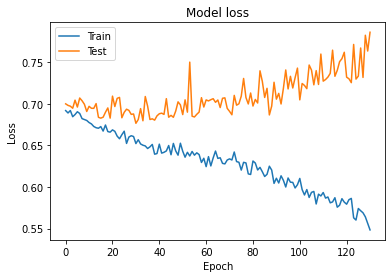

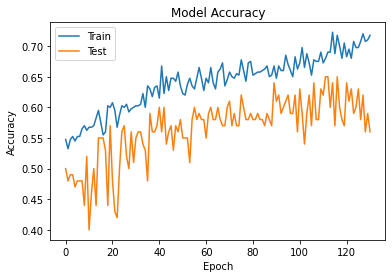

In [92]:
"""Plot the history with the aforementioned function"""
plot_loss_accuracy(history)


In [93]:
"""We evaluate the model on the test set"""
model.evaluate(X_test,y_test)

1/1 [==============================] - 0s 16ms/step - loss: 0.7901 - accuracy: 0.3333


[0.790126621723175, 0.3333333432674408]

Exploration to see if stationarizing the data leads to better results

In [94]:
"""Now we try to stationarize the data in addition to scaling them
to see if we obtain different results"""

"""Scaling the Data Frames and retrieving the column names"""

"""We use a MinMax scaler to scale our data"""
scaler = MinMaxScaler(feature_range=(0,1))

"""We scale the train and test data"""
df_train_scaled = scaler.fit_transform(df_train)
df_test_scaled = scaler.transform(df_test)

"""As the minmaxscaler erases the columns, we set our scaled data as dataframes
and we give them them column names of the unscaled data frames"""
df_train_scale_DF = pd.DataFrame(df_train_scaled)
df_train_scale_DF.columns=df_train.columns
df_train_scale_DF=df_train_scale_DF.diff()
df_train_scale_DF.dropna(inplace=True)
df_test_scaled_DF = pd.DataFrame(df_test_scaled)
df_test_scaled_DF.columns=df_test.columns
df_test_scaled_DF=df_test_scaled_DF.diff()
df_test_scaled_DF.dropna(inplace=True)
#df_train_scale_DF["Movement_predict_categorical"] = f

In [95]:
X_train, y_train = get_X_y(df_train_scale_DF, 500, 31)
X_test, y_test = get_X_y(df_test_scaled_DF, 6, 31)
X_train.shape


(500, 30, 17)

In [96]:
def initialize__compile_model():
    model = Sequential()
    model.add(layers.GRU(units=20,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[-1]),activation="tanh"))
    model.add(layers.GRU(units=20,return_sequences=True,activation="tanh"))
    model.add(layers.Dropout(0.4))
    model.add(Dense(units=10,activation="relu"))
    model.add(Dense(units=1,activation="sigmoid"))
    model.compile(optimizer="rmsprop",loss='binary_crossentropy', metrics=['accuracy'])
    return model
    

In [97]:
es = EarlyStopping(monitor='val_loss', verbose=1, patience=100, restore_best_weights=True)

model=initialize__compile_model()

history=model.fit(X_train,y_train,epochs=200,batch_size=16,validation_split=0.2,callbacks=[es])

Epoch 1/200
25/25 [==============================] - 2s 49ms/step - loss: 0.5002 - accuracy: 0.4703 - val_loss: 0.2988 - val_accuracy: 0.3600
Epoch 2/200
25/25 [==============================] - 0s 10ms/step - loss: 0.1774 - accuracy: 0.4700 - val_loss: 0.2556 - val_accuracy: 0.3600
Epoch 3/200
25/25 [==============================] - 0s 9ms/step - loss: 0.1446 - accuracy: 0.4700 - val_loss: 0.2627 - val_accuracy: 0.3600
Epoch 4/200
25/25 [==============================] - 0s 20ms/step - loss: 0.1151 - accuracy: 0.4700 - val_loss: 0.2766 - val_accuracy: 0.3600
Epoch 5/200
25/25 [==============================] - 0s 9ms/step - loss: 0.1245 - accuracy: 0.4700 - val_loss: 0.2749 - val_accuracy: 0.3600
Epoch 6/200
25/25 [==============================] - 0s 9ms/step - loss: 0.1136 - accuracy: 0.4700 - val_loss: 0.2776 - val_accuracy: 0.3600
Epoch 7/200
25/25 [==============================] - 0s 9ms/step - loss: 0.1162 - accuracy: 0.4700 - val_loss: 0.2764 - val_accuracy: 0.3600
Epoch 8/20

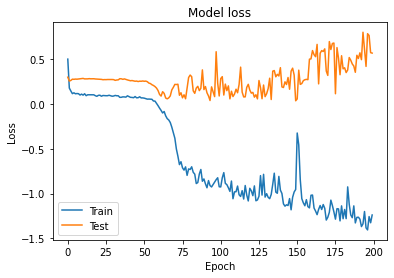

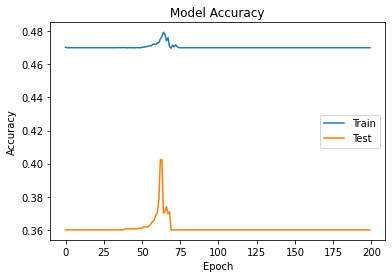

In [98]:
plot_loss_accuracy(history)

In [99]:
model.evaluate(X_test,y_test)

1/1 [==============================] - 0s 16ms/step - loss: -0.2756 - accuracy: 0.6667


[-0.275572806596756, 0.6666666865348816]